### Práctica 3: Bolsas de Términos, o BoW y Esquemas de Pesado
<p><kbd>0226594</kbd> Sara Carolina Gómez Delgado  </p>
<p>Clase de Procesamiento de Lenguaje Natural</p>

In [2]:
import nltk
import matplotlib
from sklearn.ensemble import RandomForestClassifier
import pandas
from bs4 import BeautifulSoup
import numpy
import scipy

In [3]:
def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []
    with open(path_corpus, "r",encoding="utf8") as f_corpus, open(path_truth, "r",encoding="utf8") as f_truth:
        for tuit in f_corpus:
            tr_txt += [tuit]
        for label in f_truth:
            tr_y += [label] 
    return tr_txt, tr_y

In [4]:
tr_txt, tr_y = get_texts_from_file("./mex_train.txt", "./mex_train_labels.txt")

In [5]:
len(tr_txt)

5544

In [6]:
len(tr_y)

5544

In [7]:
# Split no funciona porque tenemos signos de puntuación y no sólo espacios.
tr_txt[5].split()

['putos.',
 'no',
 'tienen',
 'madre.',
 'ambriados',
 'mantenidos.',
 'ojetes.',
 'como',
 'es',
 'posible.',
 'mejor',
 'matarlos']

## Tokenizar un tuit

In [8]:
import nltk 
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

In [9]:
tokenizer.tokenize(tr_txt[5])

['putos',
 '.',
 'no',
 'tienen',
 'madre',
 '.',
 'ambriados',
 'mantenidos',
 '.',
 'ojetes',
 '.',
 'como',
 'es',
 'posible',
 '.',
 'mejor',
 'matarlos']

In [10]:
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += tokenizer.tokenize(doc) # lista con documentos divididos por espacios (contando signos de puntuación)

In [11]:
len(set(corpus_palabras))

13580

In [12]:
fdist = nltk.FreqDist(corpus_palabras) # cuántas veces aparece cada palabra

In [13]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict] #lista de pares ordenada (más frecuente a menos)
    aux.sort()
    aux.reverse()
    return aux #regresa el objeto ordenado en reversa

In [14]:
V = sortFreqDict(fdist)
V = V[:5000]
V[:10]

[(3383, 'que'),
 (3357, 'de'),
 (2774, '.'),
 (2629, 'a'),
 (2433, 'la'),
 (2266, 'y'),
 (1824, 'no'),
 (1613, 'me'),
 (1505, '!'),
 (1303, 'el')]

In [15]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word]=cont
    cont+=1
print(len(dict_indices))

5000


In [16]:
list(dict_indices)[:5]

['que', 'de', '.', 'a', 'la']

In [17]:
val_txt, val_y = get_texts_from_file("./mex_val.txt", "./mex_val_labels.txt")

Counter({'0\n': 3563, '1\n': 1981})


Text(0.5, 0, 'Class')

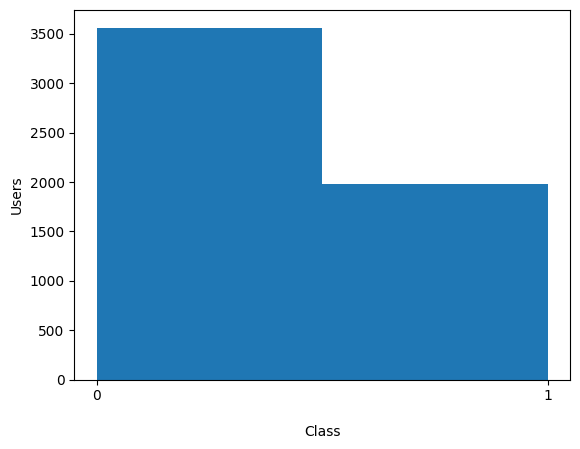

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(tr_y))

plt.hist(tr_y, bins=len(set(tr_y)))
plt.ylabel('Users')
plt.xlabel('Class')

Counter({'0\n': 397, '1\n': 219})


Text(0.5, 0, 'Class')

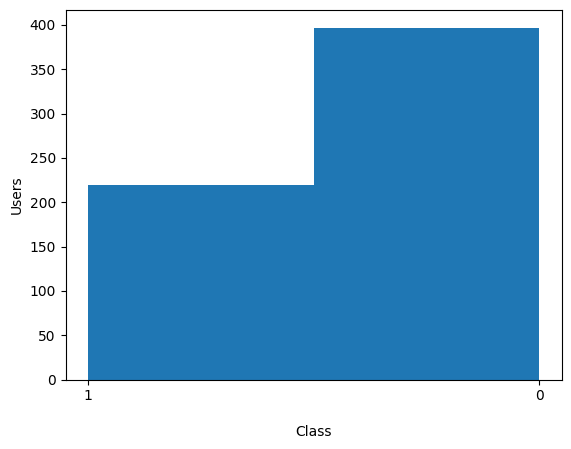

In [19]:
val_txt, val_y = get_texts_from_file('./mex_val.txt', "./mex_val_labels.txt")

from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(val_y))
plt.hist(val_y, bins=len(set(val_y)))

plt.ylabel('Users')
plt.xlabel('Class')

## Bag of Words (BOW)

In [20]:
import numpy as np
#   * tokenizer.tokenize(): recibe un tweet y lo separa de forma inteligente (por palabras). No se hace con split porque no sólo se separan por espacios
#   * FreqDist: mapa (regresa la frecuencia [cubetas de palabras])
#   * dict_indices: global (por todos los tweets [cubeta ordenada ascendente])


### <kbd>Binary</kbd>
* ¿Tiene la palabra? 1
* ¿no la tiene? 0

In [21]:
def binary_BOW(tweets, V, dict_indices): #string de tweets, vocabulario (frecuencia de palabras), diccionario de indices
    BOW = np.zeros((len(tweets),len(V)), dtype=int) #tweets * vocabulario  (si la palabra existe, pongo un 1 en mi matriz, si no, escribo un 0)
    for i, tweet in enumerate(tweets):
        word_map = nltk.FreqDist(tokenizer.tokenize(tweet))
        for word in word_map:
            if word in dict_indices:
                BOW[i, dict_indices[word]] = 1 
    return BOW  #bolsa de palabras (Número de documentos * número de palabras )
BOW_tr = binary_BOW(tr_txt, V, dict_indices)
print(BOW_tr[0,:])


[1 1 0 ... 0 0 0]


### <kbd>Term Frequency BoW</kbd>
* Cada casilla representa la frecuencia de la palabra

In [22]:
def freq_BOW(tweets, V, dict_indices):
    BOW = np.zeros((len(tweets),len(V)), dtype=int)
    for i, tweet in enumerate(tweets):
        word_map = nltk.FreqDist(tokenizer.tokenize(tweet))
        for word in word_map:
            if word in dict_indices:
                BOW[i, dict_indices[word]] = word_map[word]
    return BOW
BOW_tr = freq_BOW(tr_txt, V, dict_indices)
print(BOW_tr[0,:])

[1 2 0 ... 0 0 0]


### <kbd>TF-IDF BoW</kbd>

$$ w_{i,j} = tf(t_j, d_i) * idf(t_j) $$

$$  tf(t_j, d_i) =  frecuencia \hspace{1mm} de \hspace{1mm} t_j \hspace{1mm} en  \hspace{1mm} el \hspace{1mm} documento \hspace{1mm} d_i $$

$$ idf(t_j) = log(\frac{Num Documentos} {Num Docs \hspace{1mm} que \hspace{1mm} contienen \hspace{1mm} t_j }) $$




In [23]:
def tfidf_BOW(tweets, V, dict_indices):
    map_ = dict() #creo un "mapa" o diccionario para contar el número de documentos que contienen la palabra t_j
    BOW = np.zeros((len(tweets),len(V)), dtype = float) # float porque si no, deja los 0.00529938 como 0
    for i, tweet in enumerate(tweets):
        word_map = nltk.FreqDist(tokenizer.tokenize(tweet))
        for word in word_map:
            if word in dict_indices:
                if not word in map_:
                    map_[word] = 0  #inicializar el mapa 
                map_[word] +=1
                BOW[i, dict_indices[word]] = word_map[word] / len(tokenizer.tokenize(tweet))
    for i, tweet in enumerate(tweets):
        word_map = nltk.FreqDist(tokenizer.tokenize(tweet))
        for word in word_map:
            if word in dict_indices:
                BOW[i, dict_indices[word]] *= np.log( len(tweets) / map_[word])  # Ndocs = len(tweets) / Ndocs con t_j
    return BOW

BOW_tr = tfidf_BOW(tr_txt, V, dict_indices)
print(BOW_tr.shape)
print(BOW_tr[0,:])

(5544, 5000)
[0.03803945 0.07344264 0.         ... 0.         0.         0.        ]


## Comparison 

In [24]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV    
from sklearn import metrics 
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support

parameters = {'C': [.05, .25, 1, 2]} # complejidad del algoritmo
svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=5)


def predVSreal(y_true, y_pred, BOW_tr, BOW_val):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average = 'macro', pos_label = 1)
    print("****** SHAPES ******")
    print("Train:", BOW_tr.shape)
    print("Real:", BOW_val.shape)
    print("\n****** CONFUSION MATRIX ******")
    print(confusion_matrix(y_true, y_pred))
    print("\n****** CLASSIFICATION REPORT ******")
    print(metrics.classification_report(y_true, y_pred))

#### <kbd>Binary</kbd>

In [25]:
BOW_tr = binary_BOW(tr_txt, V, dict_indices)
BOW_val = binary_BOW(val_txt, V, dict_indices)

# visualization 
grid.fit(BOW_tr, tr_y)
preds = grid.predict(BOW_val)

# confusion matrix & classification report
predVSreal(val_y, preds, BOW_tr, BOW_val)

****** SHAPES ******
Train: (5544, 5000)
Real: (616, 5000)

****** CONFUSION MATRIX ******
[[329  68]
 [ 47 172]]

****** CLASSIFICATION REPORT ******
              precision    recall  f1-score   support

          0
       0.88      0.83      0.85       397
          1
       0.72      0.79      0.75       219

    accuracy                           0.81       616
   macro avg       0.80      0.81      0.80       616
weighted avg       0.82      0.81      0.82       616



#### Falsos negativos (se predijo como no-agresivo, pero sí lo era)

In [26]:
false_negatives = 0
FN_tweets = []
for i, tweet in enumerate(val_txt): #(iterador, tweet)
    if val_y[i] and preds[i] != val_y[i]: #sí era agresivo pero se etiquetó como no-agresivo...
        false_negatives+=1
        FN_tweets.append(tweet)
        # print(tweet)
print("***** FALSE NEGATIVES *****")
print(false_negatives)
for fn in FN_tweets:
    print("----> ", fn)

***** FALSE NEGATIVES *****
115
---->  así debería ser siempre para que se mueran a la verga

---->  cada día me siento como un perro ovejero tratando de cuidar sus ovejas vale madre pinches rateros póngase a trabajar.😤

---->  me tienen hasta la verga con sus putos #boomerang pendejos y sin sentido.

---->  ya a cualquier prieto le dicen licenciado peludito tengan madre

---->  como cuando llevabas hot dogs a la primaria y cada que le dabas una mordida tus amigos se agarraban la verga y hacían como que les dolía 😂

---->  partido nudista de invernalia. a huevo putos. jajaja

---->  su "pura vida" quedó en "pura verga" que se tragaron pinches ticos piojosos

---->  vengo aprendiendo un chingo de pinches putas groserias porque viene un cabron hablando por telefono en el pinche camion

---->  jajajjaja y si no tienes a ese amigo el joto eres tú jajajaja

---->  fnatic me acaba de cagar el pick'em no vuelvo a confiar en los putos europeos

---->  ya putos tirenles un oscar que son re buen

#### <kbd>Term Frequency BoW</kbd>


In [27]:
BOW_tr = freq_BOW(tr_txt, V, dict_indices)
BOW_val = freq_BOW(val_txt, V, dict_indices)

# visualization 
#grid.fit(BOW_tr, tr_y)
preds = grid.predict(BOW_val)


In [28]:
grid.fit(BOW_tr, tr_y)

GridSearchCV(cv=5, estimator=LinearSVC(class_weight='balanced'), n_jobs=8,
             param_grid={'C': [0.05, 0.25, 1, 2]}, scoring='f1_macro')

In [29]:
# confusion matrix & classification report
predVSreal(val_y, preds, BOW_tr, BOW_val)

****** SHAPES ******
Train: (5544, 5000)
Real: (616, 5000)

****** CONFUSION MATRIX ******
[[326  71]
 [ 47 172]]

****** CLASSIFICATION REPORT ******
              precision    recall  f1-score   support

          0
       0.87      0.82      0.85       397
          1
       0.71      0.79      0.74       219

    accuracy                           0.81       616
   macro avg       0.79      0.80      0.80       616
weighted avg       0.81      0.81      0.81       616



#### <kbd>TF-IDF BoW</kbd>

In [30]:
BOW_tr = tfidf_BOW(tr_txt, V, dict_indices)
BOW_val = tfidf_BOW(val_txt, V, dict_indices)

# visualization 
# grid.fit(BOW_tr, tr_y)
preds = grid.predict(BOW_val) 

# confusion matrix & classification report
predVSreal(val_y, preds, BOW_tr, BOW_val)

****** SHAPES ******
Train: (5544, 5000)
Real: (616, 5000)

****** CONFUSION MATRIX ******
[[395   2]
 [204  15]]

****** CLASSIFICATION REPORT ******
              precision    recall  f1-score   support

          0
       0.66      0.99      0.79       397
          1
       0.88      0.07      0.13       219

    accuracy                           0.67       616
   macro avg       0.77      0.53      0.46       616
weighted avg       0.74      0.67      0.56       616



In [31]:
grid.fit(BOW_tr, tr_y)

GridSearchCV(cv=5, estimator=LinearSVC(class_weight='balanced'), n_jobs=8,
             param_grid={'C': [0.05, 0.25, 1, 2]}, scoring='f1_macro')

## Compute DOR

In [34]:
import math

def compute_dor(TR): # 
    TR_subset_in = TR
    DTR = np.zeros((TR_subset_in.shape[1], TR_subset_in.shape[0]), dtype=float)
    print(TR.shape)
    print(DTR.shape)

    tam_V = TR_subset_in.shape[1]
    for doc, i in zip(TR_subset_in, range(len(TR_subset_in))):
        nonzero_positions = np.nonzero(doc)[0]
        tam_v = len(nonzero_positions)
        for term in nonzero_positions:
            DTR[term, i] = (1 + math.log10(doc[term])) * math.log10(tam_V/tam_v)
    return DTR

In [37]:
from sklearn import preprocessing
DOR_base = compute_dor(freq_BOW(tr_txt, V, dict_indices))

(5544, 5000)
(5000, 5544)


In [38]:
DOR_base

array([[2.4202164 , 2.35654732, 3.28234092, ..., 0.        , 0.        ,
        0.        ],
       [3.14877414, 0.        , 0.        , ..., 0.        , 0.        ,
        2.58502665],
       [0.        , 0.        , 0.        , ..., 2.65757732, 0.        ,
        2.58502665],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [39]:
DOR_base = preprocessing.normalize(DOR_base, norm="l2")

In [40]:
from sklearn.feature_selection import SelectKBest, chi2

In [41]:
feats = SelectKBest(chi2, k=1000) #features 
feats.fit(BOW_tr, tr_y) #entrenar

SelectKBest(k=1000, score_func=<function chi2 at 0x0000016C38686160>)

In [42]:
best = feats.get_support(indices=True) #regresa el número de columna de las 1000 mejores
best

array([   3,    4,    7,    8,   10,   11,   12,   16,   18,   22,   27,
         32,   33,   34,   35,   41,   43,   44,   45,   46,   50,   52,
         53,   54,   55,   56,   58,   60,   63,   64,   65,   68,   70,
         71,   73,   75,   77,   80,   82,   85,   86,   88,   90,   93,
         97,   99,  100,  104,  105,  106,  109,  110,  113,  115,  117,
        118,  119,  124,  127,  133,  135,  136,  138,  141,  142,  144,
        145,  146,  148,  154,  158,  165,  167,  171,  173,  174,  175,
        177,  179,  182,  188,  189,  192,  194,  195,  202,  205,  210,
        214,  219,  220,  221,  222,  224,  225,  228,  231,  232,  233,
        236,  238,  245,  247,  253,  255,  256,  257,  259,  260,  261,
        262,  263,  269,  274,  282,  287,  288,  290,  291,  294,  300,
        304,  305,  308,  309,  315,  317,  320,  325,  327,  328,  329,
        330,  332,  349,  351,  352,  353,  354,  355,  356,  361,  368,
        371,  372,  373,  374,  375,  377,  378,  3

In [43]:
len(best)

1000

In [44]:
# dict_indices["arriba"] = 121
# dict_indice_invertido[121] = "arriba"

dict_indice_invertido = {}
for w in dict_indices:
    dict_indice_invertido[dict_indices[w]] = w

In [46]:
target_words = [dict_indice_invertido[index] for index in best] 
target_words

['a',
 'la',
 'me',
 '!',
 '@usuario',
 'en',
 'verga',
 'los',
 'putos',
 'mi',
 '"',
 'loca',
 'su',
 'tu',
 'una',
 'del',
 'yo',
 'pinche',
 'cuando',
 'puta',
 ':',
 'son',
 'estoy',
 '¿',
 'les',
 'hdp',
 'sus',
 'joto',
 'esta',
 'está',
 '…',
 'q',
 'soy',
 'vale',
 'puto',
 'pinches',
 'mis',
 'quiero',
 'luchona',
 'eres',
 'vida',
 'mierda',
 '️',
 '¡',
 'tiene',
 'hoy',
 'tengo',
 'día',
 'maricon',
 'hijos',
 'pendejo',
 '-',
 'hijo',
 'esos',
 '😭',
 'van',
 'tus',
 'alguien',
 '”',
 'mamá',
 'pendeja',
 'sí',
 '😍',
 'madres',
 'dos',
 'vas',
 'sé',
 'méxico',
 '❤',
 'amor',
 'también',
 'días',
 'puedo',
 'culo',
 'mundial',
 'mañana',
 'años',
 '2',
 'mamar',
 'pendejos',
 'chingas',
 'alv',
 'menos',
 'cosas',
 'chingar',
 'putita',
 'mil',
 'ojalá',
 'estaba',
 'deja',
 'd',
 'he',
 'estás',
 've',
 'sabes',
 'ustedes',
 'valer',
 'unos',
 'rt',
 'estos',
 'siento',
 'hija',
 'chinga',
 'después',
 'amo',
 ';',
 'veo',
 'pueden',
 'noche',
 'ha',
 'chinguen',
 ':(',
 '

In [47]:
t_words = target_words

In [51]:
# dict_indices['palabra'] = 201
target_matrix = np.array([DOR_base[dict_indices[word]] for word in t_words])

In [52]:
target_matrix.shape

(1000, 5544)

In [53]:
from tsne import tsne

In [54]:
reduced_matrix = tsne(target_matrix, 2) #se reduce la dimensión

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.093128
Iteration 10: error is 17.490520
Iteration 20: error is 17.159715
Iteration 30: error is 16.981563
Iteration 40: error is 17.005035
Iteration 50: error is 16.992565
Iteration 60: error is 16.957870
Iteration 70: error is 16.960397
Iteration 80: error is 16.947614
Iteration 90: error is 16.937792
Iteration 100: error is 16.935744
Iteration 110: error is 1.988145
Iteration 120: error is 1.511343
Iteration 130: error is 1.320704
Iteration 140: error is 1.212078
Iteration 150: error is 1.143402
Iteration 160: error is 1.098258
Iteration 170: error is 1.065689
Iteration 180: error is 1.039598
Iteration 190: error is 1.018583
Iteration 200: error is 1.002202
Iteration 210: error is 0.989367
Iteration 220: error is 0.978593
Iteration 230: error is 0.969318
Iteration 240: error is 0.961491
Iteration 250: error is

In [55]:
reduced_matrix.shape

(1000, 2)

C:\Users\scago\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  func(*args, **kwargs)
C:\Users\scago\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  func(*args, **kwargs)
C:\Users\scago\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 129316 (\N{DROOLING FACE}) missing from current font.
  func(*args, **kwargs)
C:\Users\scago\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from current font.
  func(*args, **kwargs)
C:\Users\scago\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 129318 (\N{FACE PALM}) missing from current font.
  func(*args, **kwargs)
C:\Users\scago\AppData\Roaming\Python\Python311

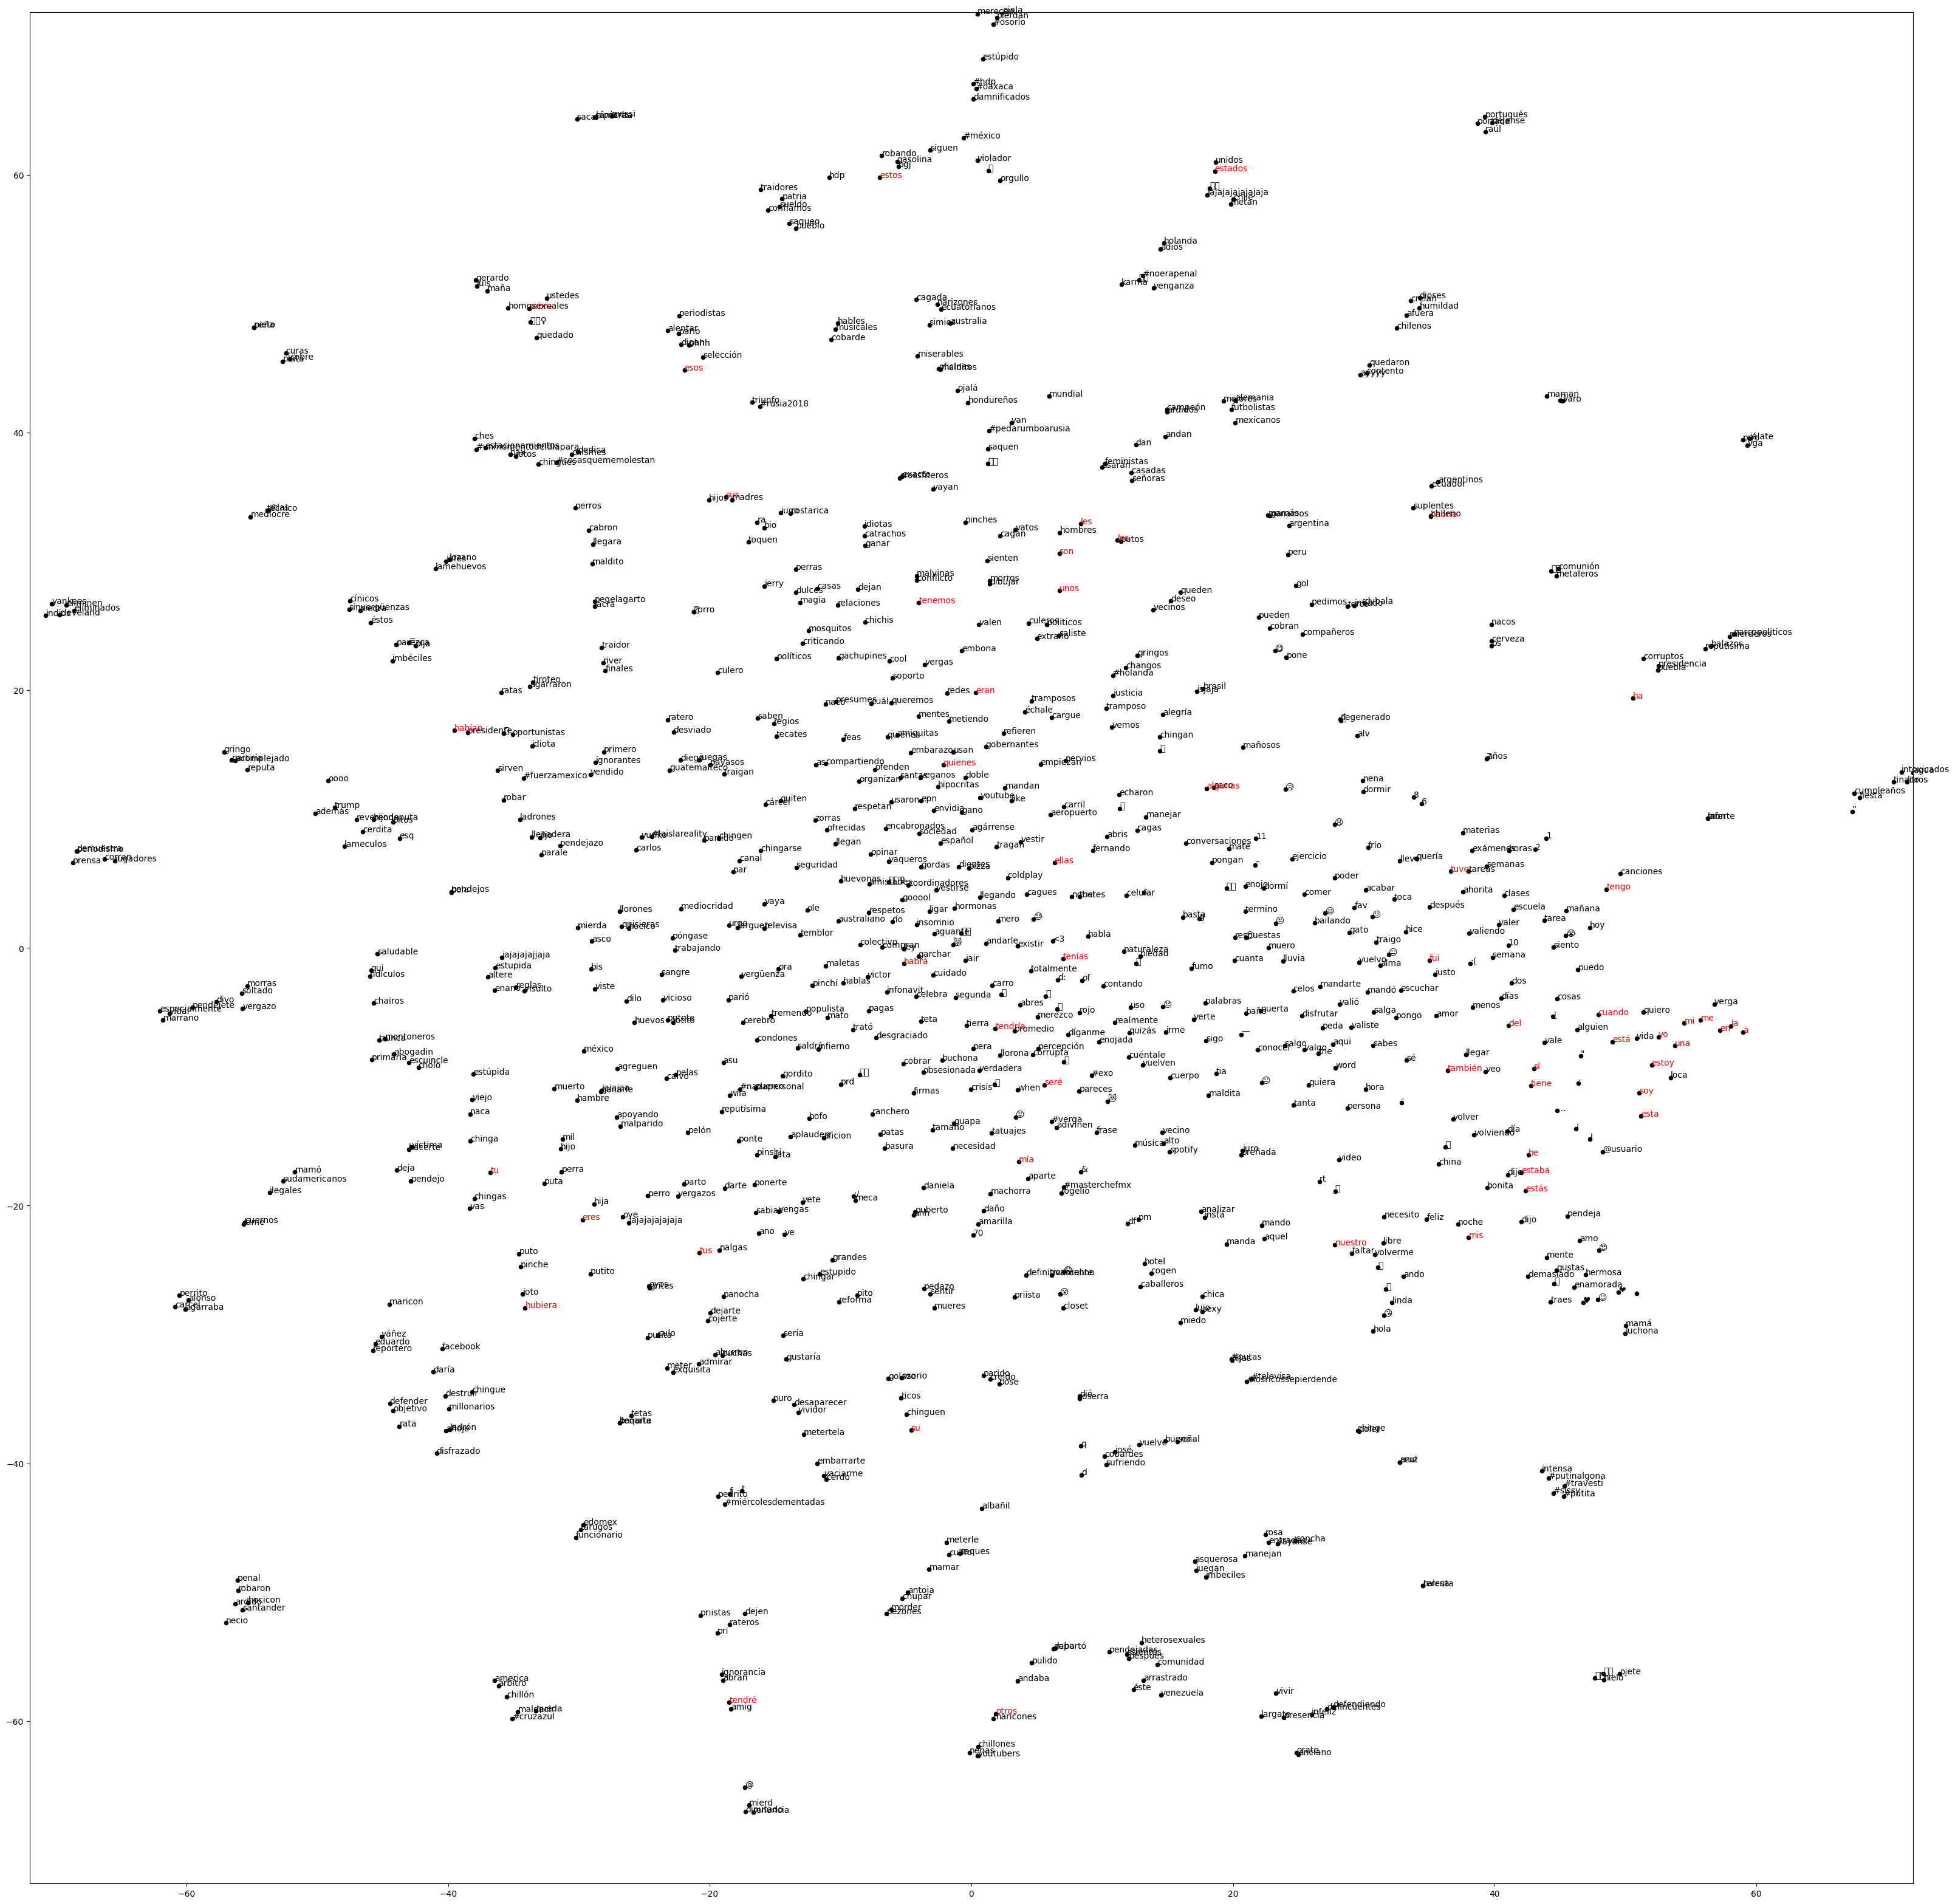

In [61]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]

import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords

sw = set(stopwords.words("spanish"))

plt.figure(figsize=(40, 40), dpi=100)
plt.xlim((-max_x,max_x)) 
plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color="black");

for idx, word in enumerate(t_words[:]):
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]  
    if word in sw:
            plt.annotate(word, (x,y), color="red")
    else: 
        plt.annotate(word, (x,y), color="black")